# Análise da Popularidade de Músicas

Este projeto visa explorar e prever a popularidade de músicas utilizando dados disponíveis em um conjunto de dados do Kaggle. O objetivo é aplicar técnicas de ciência de dados e machine learning para desenvolver um modelo preditivo que classifique a popularidade de faixas musicais. O processo inclui a limpeza e preparação dos dados, análise exploratória, seleção de features, construção do modelo e avaliação de desempenho.

Aqui ocorre a importação das bibliotecas que serão utilizadas no projeto, incluindo também o modelo preditivo.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

Carrega os datasets dos dados de teste e de treino fornecidos na plataforma kaggle, a partir de dados no formato de CSV.

In [5]:

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Limpeza dos Dados

Nesta seção, colunas irrelevantes que não contribuirão para a análise são removidas, e a coluna explicit é convertida de booleano para inteiro. Este processo ajuda a garantir que o modelo utilize apenas as informações relevantes.

In [6]:
# Remover colunas irrelevantes
train_data = train_data.drop(columns=['track_id', 'track_name'])
test_data = test_data.drop(columns=['track_id', 'track_name'])

# Organiza a coluna explicit(bool) e classifica no 
# astype transforma o bool em int. False=0 e True=1. 
train_data['explicit'] = train_data['explicit'].astype(int)
test_data['explicit'] = test_data['explicit'].astype(int)


## Análise Exploratória de Dados 

A Análise Exploratória de Dados (EDA) é uma etapa vital que permite entender melhor as características do conjunto de dados, identificar padrões, tendências e possíveis problemas nos dados.

 Essa análise ajuda a identificar padrões e tendências nos dados. As visualizações permitem uma melhor comunicação dos insights, que serão utilizados na modelagem e seleção de features.

Além disso, o trecho de código abaixo realizada a verificação de valores nulos. 

In [7]:
# 1. Verificação de valores ausentes
missing_values = train_data.isnull().sum()
print("Valores Ausentes:\n", missing_values[missing_values > 0])

# 2. Estatísticas descritivas
print("Estatísticas Descritivas:\n", train_data.describe())

Valores Ausentes:
 Series([], dtype: int64)
Estatísticas Descritivas:
        track_unique_id   duration_ms      explicit  danceability  \
count     79800.000000  7.980000e+04  79800.000000  79800.000000   
mean      57140.494048  2.279022e+05      0.085689      0.567318   
std       32993.196225  1.050599e+05      0.279906      0.173110   
min           0.000000  1.338600e+04      0.000000      0.000000   
25%       28450.500000  1.744360e+05      0.000000      0.456000   
50%       57234.000000  2.128130e+05      0.000000      0.581000   
75%       85774.250000  2.614260e+05      0.000000      0.695000   
max      113998.000000  5.237295e+06      1.000000      0.985000   

             energy           key      loudness          mode   speechiness  \
count  79800.000000  79800.000000  79800.000000  79800.000000  79800.000000   
mean       0.641529      5.307043     -8.263741      0.637732      0.084750   
std        0.251441      3.562186      5.035504      0.480659      0.105657   


## Codificação de Variáveis Categóricas

As variáveis categóricas são codificadas usando um método de codificação alvo, que mapeia a média da popularidade de cada categoria. Isso é feito para assegurar que a informação essencial não seja perdida durante a transformação.

In [8]:
# Definir uma função para codificação manual baseada na média da variável alvo
def target_encode(train_col, target_col, test_col):
    # Calcular a média da variável alvo por categoria   
    means = train_data.groupby(by=train_col)[target_col].mean()
    
    # Mapear a média calculada para o conjunto de treino
    train_encoded = train_data[train_col].map(means)
    
    # Aplicar o mapeamento também para os dados de teste (com valores conhecidos no treino)
    test_encoded = test_data[test_col].map(means)
    global_mean = train_data[target_col].mean()
    test_encoded = test_encoded.fillna(global_mean)
    
    return train_encoded, test_encoded

# Codificar as variáveis categóricas: 'artists', 'track_genre' e 'album_name'
train_data['artists'], test_data['artists'] = target_encode('artists', 'popularity_target', 'artists')
train_data['track_genre'], test_data['track_genre'] = target_encode('track_genre', 'popularity_target', 'track_genre')
train_data['album_name'], test_data['album_name'] = target_encode('album_name', 'popularity_target', 'album_name')

# Aplicando a codificação alvo (Target Encoding)
# Criar variável de contagem de artistas
train_data['num_artists'] = train_data['artists'].apply(lambda x: len(x.split(';')) if isinstance(x, str) else 0)
test_data['num_artists'] = test_data['artists'].apply(lambda x: len(x.split(';')) if isinstance(x, str) else 0)

##  Normalização dos Dados

As variáveis numéricas são normalizadas usando o MinMaxScaler. A normalização ajuda a colocar todas as características na mesma escala, melhorando o desempenho dos modelos de machine learning.

In [9]:
# Normalizar colunas numéricas para garantir que estejam na mesma escala
numeric_features = ['tempo', 'loudness', 'duration_ms', 'num_artists']
scaler = MinMaxScaler()

# Ajustar o scaler e transformar os dados de treino
train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
# Transformar os dados de teste
test_data[numeric_features] = scaler.transform(test_data[numeric_features])


## Separação de Features e Target

Os dados são separados em variáveis independentes (features) e a variável dependente (target) para o treinamento do modelo.

In [10]:
# Separar os dados em features (X) e target (y)
X = train_data.drop(columns=['popularity_target', 'artists', 'track_unique_id'])
y = train_data['popularity_target']
X_test = test_data.drop(columns=['artists', 'track_unique_id'])


##  Divisão dos Dados em Treino e Validação

O conjunto de treino é dividido em subconjuntos de treino e validação. Isso permite que o modelo seja avaliado em um conjunto de dados que não foi utilizado durante o treinamento.

In [11]:
# Dividir o conjunto de treino em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


## Construção e Avaliação do Modelo

Um modelo de Random Forest é treinado e avaliado usando várias métricas. Isso fornece uma visão clara do desempenho do modelo. 

O modelo de Random Forest é avaliado com base em métricas como acurácia, precisão, recall e F1-score. Essas métricas são essenciais para entender o desempenho do modelo.

In [12]:
# Criar e treinar o modelo de Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,        # Número de árvores 
    max_depth=30,            # Profundidade das árvores
    min_samples_split=2,     # Mínimo de amostras para um nó
    min_samples_leaf=1,      # Mínimo de amostras em folha
    random_state=42,         # Peprodutibilidade
    n_jobs=-1                # Usar todos os núcleos
)

# Ajustar o modelo nos dados de treino
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de validação
valid_preds = rf_model.predict(X_valid)

# Avaliar o modelo
accuracy = accuracy_score(y_valid, valid_preds)
precision = precision_score(y_valid, valid_preds, average='weighted')
recall = recall_score(y_valid, valid_preds, average='weighted')
f1 = f1_score(y_valid, valid_preds, average='weighted')
conf_matrix = confusion_matrix(y_valid, valid_preds)

# Exibir as métricas de avaliação do modelo
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.9714285714285714
Precision: 0.9714350355526825
Recall: 0.9714285714285714
F1 Score: 0.9714296057609729
Confusion Matrix:
[[3972  120]
 [ 108 3780]]


## Ajuste Hiperparâmetros

Nesta etapa, o modelo é treinado novamente com todo o conjunto de dados e previsões são feitas no conjunto de teste. Isso garante que o modelo seja otimizado antes da previsão final.

In [13]:
# Treinar o modelo com todo o conjunto de treino
rf_model.fit(X, y)

# Fazer previsões no conjunto de teste
test_preds = rf_model.predict(X_test)


## Criação do DataFrame de Submissão

In [14]:
# Criar o dataframe de submissão
submission = pd.DataFrame({
    'track_unique_id': test_data['track_unique_id'],  # Certifique-se de usar o campo correto para ID
    'popularity_target': test_preds.astype(int)  # Converter previsões para inteiros
})

# Agrupar por 'track_unique_id' e ajustar 'popularity_target'
submission_grouped = submission.groupby('track_unique_id', as_index=False).agg({
    'popularity_target': 'max'  # 'max' irá garantir que pelo menos um 1 seja mantido, caso exista
})

# Salvar o arquivo de submissão agrupado
submission_grouped.to_csv('submissao_spotify.csv', index=False)


## Formulação de Hipóteses

**Hipótese 1: Músicas curtas são pouco populares**

- Músicas com duração muito curta ou tendem a ter uma popularidade mais baixa, enquanto músicas com maior tempo de duração apresentam maior popularidade. Isso pode ocorrer porque o público pode preferir músicas que se encaixam em um formato mais tradicional ou que oferecem uma experiência mais envolvente, sem se tornar cansativas.

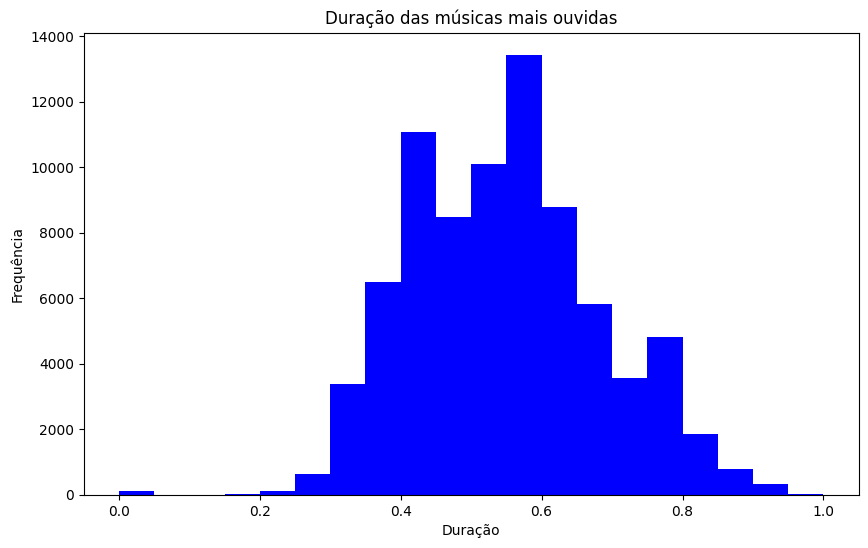

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_data['tempo'], bins=20, color='blue')  # bins define o número de intervalos
plt.xlabel('Duração')
plt.ylabel('Frequência')
plt.title('Duração das músicas mais ouvidas')
plt.show()


_Positiva:_ O gráfico acima permite validar a primeira hipótese, comprovando que as músicas de curta duração geralmente não têm boa adesão do público. Por outro lado, embora sem relação direta com a hipótese citada, vale observar que músicas longas demais também perdem popularidade. Isso indica uma preferência do público por durações mais tradicionais e medianas de músicas.


**Hipótese 2: Conteúdo Explícito Aumenta a Popularidade**

- A hipótese de que conteúdos explícitos em músicas não interferem na popularidade sugere que a presença de termos ou temáticas explícitas, como palavrões ou conteúdo sensível, não afeta a aceitação ou adesão do público. Nesse contexto, espera-se que a popularidade das músicas explícitas seja semelhante à das músicas não explícitas, indicando que o público não se preocupa significativamente com essa característica ao decidir consumir uma faixa. Para verificar essa hipótese, é necessário analisar estatisticamente a popularidade média de músicas com e sem conteúdos explícitos, observando se há uma diferença considerável ou se ambas mantêm níveis de popularidade equivalentes.

C:\Users\Inteli\AppData\Local\Temp\ipykernel_4312\33311620.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Explícitas', 'Não Explícitas'], y=[explicit_mean_popularity, non_explicit_mean_popularity], palette='Blues')


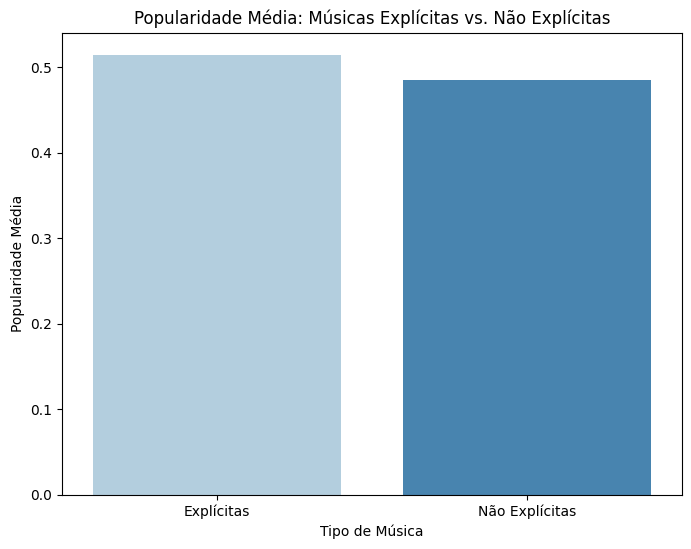

Popularidade média das músicas explícitas: 0.5144779175197426
Popularidade média das músicas não explícitas: 0.4853485375949124


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separar as músicas em explícitas e não explícitas
explicit_songs = train_data[train_data['explicit'] == 1]
non_explicit_songs = train_data[train_data['explicit'] == 0]

# Calcular a popularidade média para cada grupo
explicit_mean_popularity = explicit_songs['popularity_target'].mean()
non_explicit_mean_popularity = non_explicit_songs['popularity_target'].mean()

# Criar um gráfico de barras para visualizar a comparação
plt.figure(figsize=(8, 6))
sns.barplot(x=['Explícitas', 'Não Explícitas'], y=[explicit_mean_popularity, non_explicit_mean_popularity], palette='Blues')

# Adicionar título e rótulos aos eixos
plt.title('Popularidade Média: Músicas Explícitas vs. Não Explícitas')
plt.ylabel('Popularidade Média')
plt.xlabel('Tipo de Música')
plt.show()

# Exibir as médias
print(f"Popularidade média das músicas explícitas: {explicit_mean_popularity}")
print(f"Popularidade média das músicas não explícitas: {non_explicit_mean_popularity}")


_Positiva:_ Diante do gráfico gerado, observa-se que o conteúdo explícito não exerce uma influência negativa sobre a popularidade das músicas, assim como proposto na hipótese. De forma mais detalhada, a análise sugere que músicas com conteúdo explícito apresentam um leve aumento na popularidade. Isso indica que a presença de linguagem ou temas explícitos não afasta o público em geral e, em certas situações, pode até estar associada a um apelo maior junto a determinados ouvintes. Portanto, essa evidência sugere que o fator "explicit" não deve ser visto como um elemento limitador de sucesso no mercado musical, podendo, na verdade, agregar à popularidade de algumas faixas.

**Hipótese 3: Dançabilidade afeta positivamente a adesão do público**

- A hipótese de que a maior dançabilidade influencia positivamente a popularidade de uma música pode ser sustentada ao observar a relação entre essas duas variáveis. Músicas com uma alta taxa de dançabilidade tendem a atrair mais ouvintes, pois possuem elementos rítmicos que estimulam uma resposta física e emocional mais imediata, tornando-as ideais para ambientes como festas, academias e eventos sociais. 

C:\Users\Inteli\AppData\Local\Temp\ipykernel_4312\4100299457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='danceability_binned', y='popularity_target', data=train_data, palette='Greens')


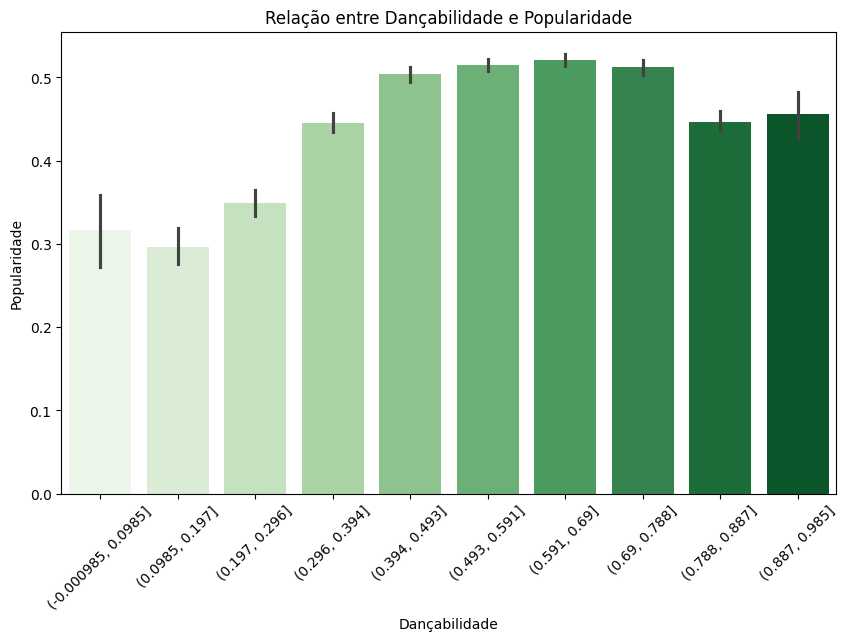

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agrupar a coluna 'danceability' em intervalos (bins)
train_data['danceability_binned'] = pd.cut(train_data['danceability'], bins=10)

# Gerar gráfico de barras para Popularidade e Danceabilidade agrupada
plt.figure(figsize=(10, 6))
sns.barplot(x='danceability_binned', y='popularity_target', data=train_data, palette='Greens')
plt.title('Relação entre Dançabilidade e Popularidade')
plt.xlabel('Dançabilidade')
plt.ylabel('Popularidade')
plt.xticks(rotation=45)
plt.show()


_Positiva:_ Essa hipótese é verificada pelo gráfico acima, que demonstra que músicas com baixa dançabilidade não atraem tanta atenção do público em comparação com as músicas de maior dançabilidade. Por outro lado, mas sem relação direta com a hipótese, o gráfico revela que níveis extremamente altos de dançabilidade reduzem, de maneira mínima, a popularidade. Nesse sentido, a hipótese se mostra verdadeira e confirma a influência positiva da dançabilidade na adesão do público.

## Conclusão


A análise realizada neste projeto oferece uma visão detalhada da popularidade das músicas e fornece um modelo preditivo que pode ser utilizado para prever a popularidade de novas faixas. A qualidade da análise e as decisões tomadas em cada etapa são cruciais para o sucesso do modelo, que deve ser avaliado continuamente para garantir sua eficácia e precisão.

Com base nos resultados das três hipóteses propostas, podemos concluir que, de fato, características específicas das músicas influenciam diretamente sua popularidade entre os ouvintes. A primeira hipótese, que propôs que músicas com tempo médio são mais populares, foi validada pelos dados. Músicas muito curtas ou muito longas tendem a ser menos populares, reforçando a preferência por faixas de duração tradicional. Isso sugere que o público valoriza um equilíbrio, evitando extremos que possam comprometer a experiência de escuta.

A segunda hipótese, relacionada ao conteúdo explícito, mostrou resultados surpreendentes. Em vez de prejudicar a popularidade, como poderia ser esperado, o conteúdo explícito parece ter um leve impacto positivo, sugerindo que, em alguns casos, músicas com temáticas mais ousadas conseguem atrair um público específico ou gerar maior engajamento. Esse achado revela que a linguagem explícita não é um fator determinante para o fracasso de uma faixa musical.

Por fim, a terceira hipótese, que vinculou maior dançabilidade à popularidade, foi confirmada, indicando que músicas com uma boa dose de ritmo e apelo físico tendem a ser mais bem recebidas. Entretanto, níveis extremamente altos de dançabilidade podem resultar em uma leve queda de popularidade, possivelmente porque faixas excessivamente rítmicas podem se tornar menos acessíveis para o público em geral. 

Combinando esses insights com a performance do modelo preditivo Random Forest, que apresentou uma excelente acurácia de 97%, podemos afirmar que as variáveis analisadas são fortes indicadores da popularidade musical, e o modelo se mostrou eficaz para prever com precisão essa tendência.